# Import

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import torch
import os

RANDOM_STATE = 42

# Train/Test Split

In [29]:
fraud_train_df = pd.read_csv('../data/fraud_mock.csv')

In [30]:
X = fraud_train_df.drop(columns='is_fraud')
y = fraud_train_df['is_fraud']

In [31]:
split_point = int(fraud_train_df['time_ind'].max() * 0.8)

train_df = fraud_train_df[fraud_train_df['time_ind'] <= split_point]
test_df = fraud_train_df[fraud_train_df['time_ind'] > split_point]

X_train = train_df.drop(columns='is_fraud')
y_train = train_df['is_fraud']
X_test = test_df.drop(columns='is_fraud')
y_test = test_df['is_fraud']

print(f"Data split: {len(X_train)} train, {len(X_test)} test rows.")

Data split: 6239040 train, 123580 test rows.


# Pipeline

## Custom createFeatures Class

In [42]:
class AccountFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass 

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X['hour_of_day'] = X['time_ind'] % 24
        X['day'] = X['time_ind']//24

        X['src_ratio'] = (X['src_new_bal'] - X['src_bal']) / (X['src_bal'] + 1)
        X['dst_ratio'] = (X['dst_new_bal'] - X['dst_bal']) / (X['dst_bal'] + 1)
        return X

## Overall Pipeline

In [33]:
num_cols = [
    'amount', 
    'src_bal',
    'dst_bal', 
    'hour_of_day',
    'day',
    'src_ratio',
    'dst_ratio'
]
cat_cols = ['transac_type'] 

cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', cat_pipe, cat_cols),
        ('num','passthrough',num_cols)],
    remainder='drop'
)

pipeline = Pipeline([
    ('feature_engineer', AccountFeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(n_estimators=200,
                            random_state=RANDOM_STATE,
                            learning_rate=0.1,
                            n_jobs=-1
                            ))
])

In [34]:
pipeline

,steps,"[('feature_engineer', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Debug preprocessing

In [35]:
X_train_sample = X_test.head(200)
y_train_sample = y_train.head(200)

print(X_train_sample['transac_type'].unique())

debug_pipeline = Pipeline([
    ('feature_engineer', AccountFeatureEngineer()),
    ('preprocessor', preprocessor)
])
debug_pipeline.fit(X_train_sample, y_train_sample)
processed_array = debug_pipeline.transform(X_train_sample.head(5))

cat_feature_names = debug_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['encoder'] \
    .get_feature_names_out(cat_cols).tolist()
num_feature_names = num_cols
all_feature_names = cat_feature_names + num_feature_names

processed_df = pd.DataFrame(
    processed_array, 
    columns=all_feature_names, 
    index=X_train_sample.head(5).index
)

print("\n--- Columns and Dtypes entering XGBoost ---")
print(processed_df.info())

print("\n--- List of Final Columns ---")
print(processed_df.columns.tolist())

['CASH_IN' 'CASH_OUT' 'PAYMENT' 'TRANSFER' 'DEBIT']

--- Columns and Dtypes entering XGBoost ---
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 6239040 to 6239044
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transac_type_CASH_IN   5 non-null      float64
 1   transac_type_CASH_OUT  5 non-null      float64
 2   transac_type_DEBIT     5 non-null      float64
 3   transac_type_PAYMENT   5 non-null      float64
 4   transac_type_TRANSFER  5 non-null      float64
 5   amount                 5 non-null      float64
 6   src_bal                5 non-null      float64
 7   dst_bal                5 non-null      float64
 8   hour_of_day            5 non-null      float64
 9   day                    5 non-null      float64
 10  src_ratio              5 non-null      float64
 11  dst_ratio              5 non-null      float64
dtypes: float64(12)
memory usage: 520.0 bytes
None

--- List of Fin

# Train & Evaluate

In [36]:
param_grid = {
    'model__max_depth': [4, 6],
    'model__learning_rate': [0.05, 0.1],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [4, 6]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [37]:
print("Best parameters found:")
print(grid_search.best_params_)

print("\nBest Recall score:")
print(grid_search.best_score_)

best_model = grid_search.best_estimator_

Best parameters found:
{'model__learning_rate': 0.1, 'model__max_depth': 6}

Best Recall score:
0.8315036466140198


In [38]:
# Fit Model 
model_dir = "../models"
model_path = os.path.join(model_dir, "fraud_model.joblib")

os.makedirs(model_dir, exist_ok=True)

joblib.dump(best_model, model_path)

['../models\\fraud_model.joblib']

Model Evaluation

1. Confusion Matrix:
[[121897     29]
 [   214   1440]]


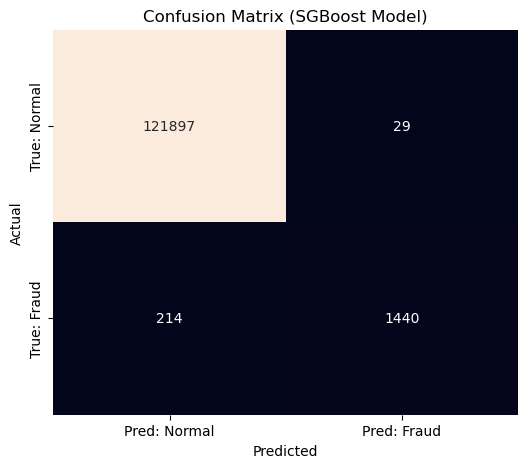


2. Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00    121926
   Fraud (1)       0.98      0.87      0.92      1654

    accuracy                           1.00    123580
   macro avg       0.99      0.94      0.96    123580
weighted avg       1.00      1.00      1.00    123580


--- Summary ---
การโกงจริงใน Test Set มีทั้งหมด: 1654 รายการ
โมเดลของคุณสามารถ จับการโกงจริงได้: 1440 รายการ
โมเดลของคุณ พลาดการโกงจริงไป: 214 รายการ
โมเดลของคุณ กล่าวหาคนบริสุทธิ์ไป: 29 รายการ


In [39]:
print("Model Evaluation")

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n1. Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Fraud'],
            yticklabels=['True: Normal', 'True: Fraud'])
plt.title("Confusion Matrix (SGBoost Model)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraud (1)'])
print("\n2. Classification Report:")
print(report)

print("\n--- Summary ---")
tn, fp, fn, tp = cm.ravel()
print(f"การโกงจริงใน Test Set มีทั้งหมด: {tp+fn} รายการ")
print(f"โมเดลของคุณสามารถ จับการโกงจริงได้: {tp} รายการ")
print(f"โมเดลของคุณ พลาดการโกงจริงไป: {fn} รายการ")
print(f"โมเดลของคุณ กล่าวหาคนบริสุทธิ์ไป: {fp} รายการ")

12
12
                  Feature  Importance
10              src_ratio    0.299042
1   transac_type_CASH_OUT    0.226704
6                 src_bal    0.133053
11              dst_ratio    0.131069
4   transac_type_TRANSFER    0.079417
0    transac_type_CASH_IN    0.061380
7                 dst_bal    0.028358
5                  amount    0.028009
8             hour_of_day    0.006310
3    transac_type_PAYMENT    0.003785
9                     day    0.002872
2      transac_type_DEBIT    0.000000


C:\Users\Admin\AppData\Local\Temp\ipykernel_15340\3005260698.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


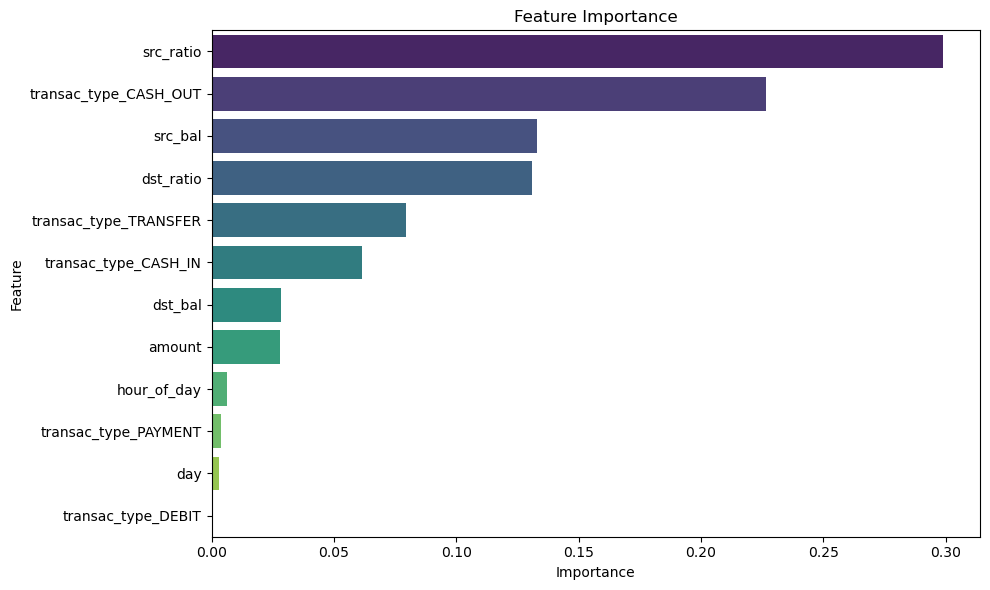

In [ ]:
filename = '../models/fraud_model.joblib'

loaded_model = joblib.load(filename)
fitted_model = loaded_model.named_steps['model'] 

importances = fitted_model.feature_importances_
feature_names = processed_df.columns.tolist()
print(len(importances))
print(len(feature_names))
feat_imp = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
})
feat_imp_sorted = feat_imp.sort_values(by='Importance', ascending=False)
print(feat_imp_sorted)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp_sorted,
    x='Importance',
    y='Feature',
    palette='viridis'
)

plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()